In [1]:
import math
import os
import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision  import transforms as TR
from pytorch3d.structures import Meshes
from collections import OrderedDict
from src.config import get_parser
from src.utilities.util import (
    grid_to_list,
    make_faces,
)
from src.utilities.alignment import align
from src.render.mesh_points_renderer import MeshPointsRenderer

In [2]:
device = torch.device('cuda')

d = torch.load('./data/npz/ada_wong_resident_evil_256.pth')
vertices = d['vertices'][None].to(device)
normals = d['normals'][None].to(device)

vertices.shape, normals.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

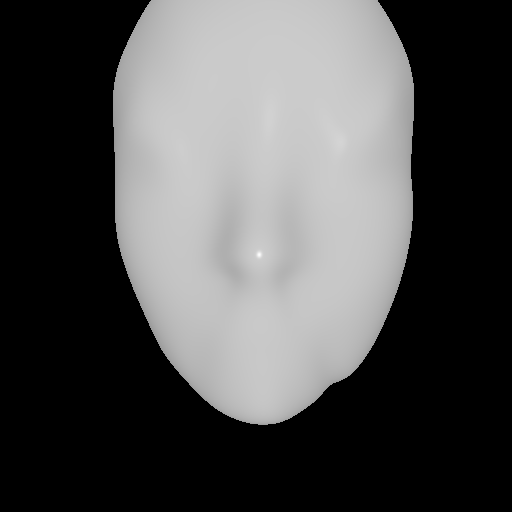

In [3]:
config = get_parser().parse_args(args=[])
config.fast_image_size = 512
config.fast_baseline_size = 256
config.viewpoint_distance = 1.25
R = MeshPointsRenderer(config).to(device)
R
colors = torch.ones_like(vertices)
renders = R(vertices.detach(), colors.detach())
TR.ToPILImage()(renders[0])

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


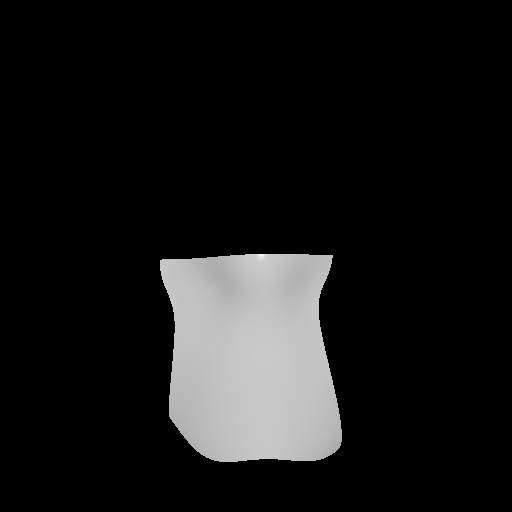

In [4]:
print(vertices.shape, normals.shape)
sz = 64
sh = 90
sv = 64
patch_vertex = vertices[:, :, sv:sv+sz, sh:sh+sz]
patch_normal = normals[:, :, sv:sv+sz, sh:sh+sz]
print(patch_vertex.shape, patch_normal.shape)

config.fast_image_size = 512
config.fast_baseline_size = patch_vertex.size(-1)
config.viewpoint_distance = 1.0
R = MeshPointsRenderer(config).to(device)
R
colors = torch.ones_like(patch_vertex)
renders = R(patch_vertex, colors.detach())
TR.ToPILImage()(renders[0])

torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


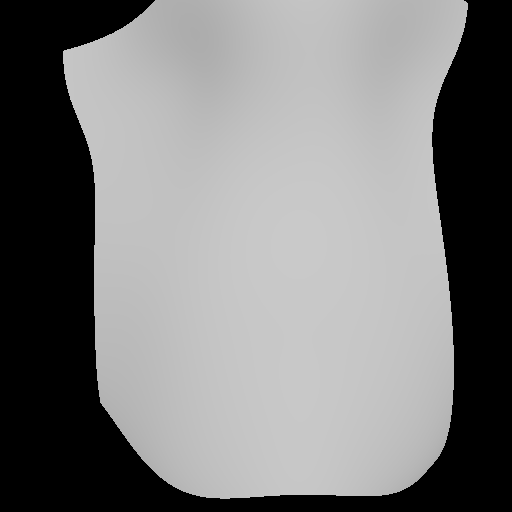

In [5]:
def list_to_grid(t):
    w = int(math.sqrt(t.size(1))) 
    return t.reshape(-1, w, w, 3).permute(0, 3, 1, 2)

print(patch_vertex.shape, patch_normal.shape)
p_v, p_n =  align(grid_to_list(patch_vertex), grid_to_list(patch_normal), rotate=False)
p_v, p_n = list_to_grid(p_v), list_to_grid(p_n)


config.fast_image_size = 512
config.fast_baseline_size = patch_vertex.size(-1)
config.viewpoint_distance = 0.8
R = MeshPointsRenderer(config).to(device)
renders = R(p_v, colors.detach())
TR.ToPILImage()(renders[0])

In [10]:
mask = torch.where(renders.detach() > 0.2, True, False)
mask.shape, mask.dtype

(torch.Size([1, 1, 512, 512]), torch.bool)

In [7]:
from torchvision import models

from typing import Union, List, Dict, Any, cast


cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256],    
}
    
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

net = make_layers(cfgs['A']).to(device)
net

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
)

In [9]:
net(renders).shape

torch.Size([1, 256, 128, 128])